# Connor Lowe
# EE 440
# Final Project
# Cartoon Effect

To run this GUI just run the below cell in a jupyter notebook

Please follow the homework submission guidelines. Be sure to zip all the necessary files including codes, images, and a project report. **In your project report, you should specify:**
 - Effects/functions you want to achieve
 - Details of the algorithm and implementation
 - Instruction on how to run all functionalities of your program
 - Comments on what you have learned and new features that can be added in the future.

In [1]:
from tkinter import filedialog
from tkinter.filedialog import askopenfilename
import tkinter as tk
import cv2
import PIL.Image, PIL.ImageTk
import numpy as np
import math
from scipy import signal, interpolate

# array length function
def array_length(a):
    counter = 0
    for char in a:
        counter += 1
    return counter

# gaussian kernel for convolution
def gaussian_kernel(l, sig):
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel = np.outer(gauss, gauss)
    return kernel / np.sum(kernel)

# convolution function
def convolution(image, kernel):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    image_row, image_col = image.shape
    kernel_row, kernel_col = kernel.shape
 
    output = np.zeros(image.shape)
 
    pad_height = int((kernel_row - 1) / 2)
    pad_width = int((kernel_col - 1) / 2)
 
    padded_image = np.zeros((image_row + (2 * pad_height), image_col + (2 * pad_width)))
    padded_image[pad_height:padded_image.shape[0] - pad_height, pad_width:padded_image.shape[1] - pad_width] = image
 
    for row in range(image_row):
        for col in range(image_col):
            output[row, col] = np.sum(kernel * padded_image[row:row + kernel_row, col:col + kernel_col])
    
    return output

# gaussion blur function
def gaussian(image, kernel_size):
    kernel = gaussian_kernel(kernel_size, sig=3)
    return convolution(image, kernel)

# bilatreal filtering
def fastBilateral(image, k, s):
    return cv2.bilateralFilter(image, k, s, s)

# cartoon effect for output
def cartoonEffect(image, k, s):
    bil = cv2.bilateralFilter(image, k, s, s)
    edges = cv2.Canny(bil, 100, 100)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges = cv2.bitwise_not(edges)
    result = np.minimum(bil, edges)
    return result

# global variables
MARGIN = 1  # px
MAXDIM = 530
DROPDOWN_WIDTH = 0.11
is_on = True

class App():
    global NEWcv_img_modify
    
    def __init__(self, window, window_title):
        self.window = window
        self.window.title(window_title)
        self.image_path = "Input Images/lena.bmp"
        
        # Load an image using OpenCV
        self.cv_img = cv2.imread(self.image_path)
        self.NEWcv_img = self.cv_img.copy()  # for recursive processing
        self.NEWcv_img_modify = None
        
        # Get the image dimensions (OpenCV stores image data as NumPy ndarray)
        self.height, self.width, no_channels = self.cv_img.shape
        
        ''' Image Display Related Code'''
        # Create a FRAME that can fit the images, BLUE
        self.frame1 = tk.Frame(self.window, width=self.width, height=self.height, bg='black')
        self.frame1.pack(fill=tk.BOTH)
        
        # Create a CANVAS for original image, YELLOW
        self.canvas0 = tk.Canvas(self.frame1, width=MAXDIM, height=MAXDIM+(3*MARGIN), bg='black')
        self.canvas0.pack(side=tk.LEFT)
        
        # Create a CANVAS for changing image, ORANGE
        self.canvas1 = tk.Canvas(self.frame1, width=MAXDIM, height=MAXDIM+(3*MARGIN), bg='black')
        self.canvas1.pack(side=tk.LEFT)
        
        # Use PIL (Pillow) to convert the NumPy ndarray to a PhotoImage
        self.photoOG = PIL.ImageTk.PhotoImage(image=PIL.Image.fromarray(self.cv_img))
        self.photo = PIL.ImageTk.PhotoImage(image=PIL.Image.fromarray(self.cv_img))
        
        # Add a PhotoImage to the Canvas (original)
        self.canvas0.create_image(MAXDIM//2, MAXDIM//2, image=self.photoOG)
        
        # Add a PhotoImage to the Canvas (changing effects)
        self.canvas1.create_image(MAXDIM//2, MAXDIM//2, image=self.photo, anchor=tk.CENTER)
        
        # Write labels for both images, font/size can be changed
        self.canvas0.create_text(MAXDIM//2, MAXDIM+(2*MARGIN),font="Tahoma 20",text="Original Photo")
        self.canvas1.create_text(MAXDIM//2, MAXDIM+(2*MARGIN),font="Tahoma 20",text="Modified Photo")
        
# ##############################################################################################
# ################################   PARAMETER TOOLBAR   #######################################
# ##############################################################################################

        # Create a FRAME that can fit the features
        self.frame2 = tk.Frame(self.window, width=self.width, height=self.height//2, bg='black')
        self.frame2.pack(side=tk.BOTTOM, fill=tk.BOTH)
        
        # Create a SCALE that lets the user choose the neighborhood size
        self.scl_ns = tk.Scale(self.frame2, from_=0, to=50, orient=tk.HORIZONTAL, showvalue=1, resolution=2,
                command = self.cartoon, length=400, sliderlength=20, label="Neighborhood Size", font="Tahoma 16")
        self.scl_ns.place(relx=0.4, rely=0.1, relwidth=0.5, relheight=0.35)
        
        # Create a SCALE that lets the user choose the neighborhood size
        self.scl_sigma = tk.Scale(self.frame2, from_=0, to=100, orient=tk.HORIZONTAL, showvalue=1, resolution=2,
                command = self.cartoon, length=400, sliderlength=20, label="Sigma", font="Tahoma 16")
        self.scl_sigma.place(relx=0.4, rely=0.45, relwidth=0.5, relheight=0.35)
        
        self.toggle_btn = tk.Button(self.frame2, text="Toggle \n edges", font="Tahoma 16", width=12, relief="raised",
                                   command=self.togEdges)
        self.toggle_btn.place(relx=0.215, rely=0.5, relwidth=0.15, relheight=0.25)
        
         # Create a buttton to import image
        self.button = tk.Button(self.frame2, text="Import image", font="Tahoma 16", command=self.browsefunc)
        self.button.place(relx=0.05, rely=0.2, relwidth=0.2, relheight=0.15)
        
        # Create a button to save the image
        self.photoSaveButton = tk.Button(self.frame2, text="Save Photo", command=self.savePhoto,
                                         font="Tahoma 16", highlightbackground = "#48484A", fg='black',
                                         activeforeground="grey")
        self.photoSaveButton.place(relx=0.047, rely=0.5, relwidth=0.15, relheight=0.15)
        
        self.window.resizable(False, False)
        self.window.mainloop()

##############################################################################################
#################################  CALLBACK FUNCTIONS  #######################################
##############################################################################################
        
    '''#################################  BLUR  ###############################'''
    # Callback for the "Blur" Scale         
    def cartoon(self, n):
        k = self.scl_ns.get()     # get value from the corresponding scale
        s = self.scl_sigma.get()  # get value from the corresponding scale
        
        if self.toggle_btn.config('relief')[-1] == 'sunken':
            self.NEWcv_img_modify = cartoonEffect(self.NEWcv_img, k, s)
        else:
            self.NEWcv_img_modify = fastBilateral(self.NEWcv_img, k, s)

        self.photo = PIL.ImageTk.PhotoImage(image = PIL.Image.fromarray(self.NEWcv_img_modify))
        self.canvas1.create_image(MAXDIM//2, MAXDIM//2, image=self.photo, anchor=tk.CENTER)
        
    def togEdges(self):
        k = self.scl_ns.get()     # get value from the corresponding scale
        s = self.scl_sigma.get()  # get value from the corresponding scale
        if self.toggle_btn.config('relief')[-1] == 'sunken':
            self.toggle_btn.config(relief="raised")
        else:
            self.toggle_btn.config(relief="sunken")
            
        if self.toggle_btn.config('relief')[-1] == 'sunken':
            self.NEWcv_img_modify = cartoonEffect(self.NEWcv_img, k, s)
        else:
            self.NEWcv_img_modify = fastBilateral(self.NEWcv_img, k, s)
            
        self.photo = PIL.ImageTk.PhotoImage(image = PIL.Image.fromarray(self.NEWcv_img_modify))
        self.canvas1.create_image(MAXDIM//2, MAXDIM//2, image=self.photo, anchor=tk.CENTER)

    # callback function to search directory for new image
    def browsefunc(self):
        self.image_path = askopenfilename(filetypes=(("jpg file", "*.jpg"), ("png file ",'*.png'), ("All files", "*.*"),))
        
        # Load an image using OpenCV
        self.cv_img = cv2.cvtColor(cv2.imread(self.image_path), cv2.COLOR_BGR2RGB)
        dim = (MAXDIM, MAXDIM+(3*MARGIN))
        self.cv_img = cv2.resize(self.cv_img, dim, interpolation = cv2.INTER_AREA)
        
        self.NEWcv_img = self.cv_img.copy()  # for recursive processing
        self.NEWcv_img_modify = None
        
        # Use PIL (Pillow) to convert the NumPy ndarray to a PhotoImage
        self.photoOG = PIL.ImageTk.PhotoImage(image=PIL.Image.fromarray(self.cv_img))
        self.photo = PIL.ImageTk.PhotoImage(image=PIL.Image.fromarray(self.cv_img))
        
        # Add a PhotoImage to the Canvas (original)
        self.canvas0.create_image(MAXDIM//2, MAXDIM//2, image=self.photoOG)
        
        # Add a PhotoImage to the Canvas (changing effects)
        self.canvas1.create_image(MAXDIM//2, MAXDIM//2, image=self.photo, anchor=tk.CENTER)
        
        # Write labels for both images, font/size can be changed
        self.canvas0.create_text(MAXDIM//2, MAXDIM+(2*MARGIN),font="Tahoma 20",text="Original Photo")
        self.canvas1.create_text(MAXDIM//2, MAXDIM+(2*MARGIN),font="Tahoma 20",text="Modified Photo")
        
    def savePhoto(self):
        filename = tk.filedialog.asksaveasfile(mode='w', defaultextension=".jpg")
        image = self.NEWcv_img_modify
        pil_image = PIL.Image.fromarray(image)
        pil_image = pil_image.convert('RGB')
        if filename:
            pil_image.save(filename)

##############################################################################################
# Create a window and pass it to the Application object
App(tk.Tk(), "Connor Lowe's Final Project")

Sample Ouput Picture

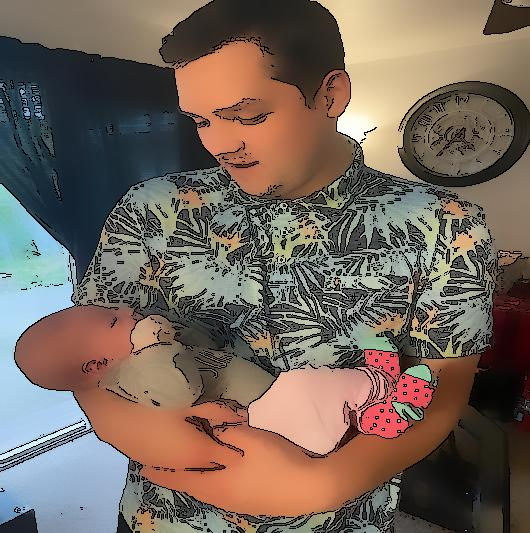